# Proyek Klasifikasi Gambar: [Flower](https://www.kaggle.com/datasets/lara311/flowers-five-classes)
- **Nama:** Clara Marsya Dekawanti
- **Email:** claramarsyaa@gmail.com
- **ID Dicoding:** MC009D5X2450

Saya membuat proyek klasifikasi bunga. Terdiri dari kelas Daisy, Dandelion, Rose, Sunflower, Tulip. Jumlah data yang dipakai untuk masing-masing kelas yaitu daisy : 501 gambar, dandelion : 596 gambar, rose : 497 gambar, sunflower : 495, dan tulip : 607 gambar. Jadi total semua jumlah data yaitu 2696 data.

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import keras
import random
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

!pip install pipreqs
!pip install tensorflowjs

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Menentukan path ke folder dataset
base_dir = '/content/drive/MyDrive/flower dataset'

# Cek isi folder
print(os.listdir(base_dir))

['dandelion', 'sunflower', 'daisy', 'rose', 'tulip']


### Plot gambar sampel untuk semua kelas

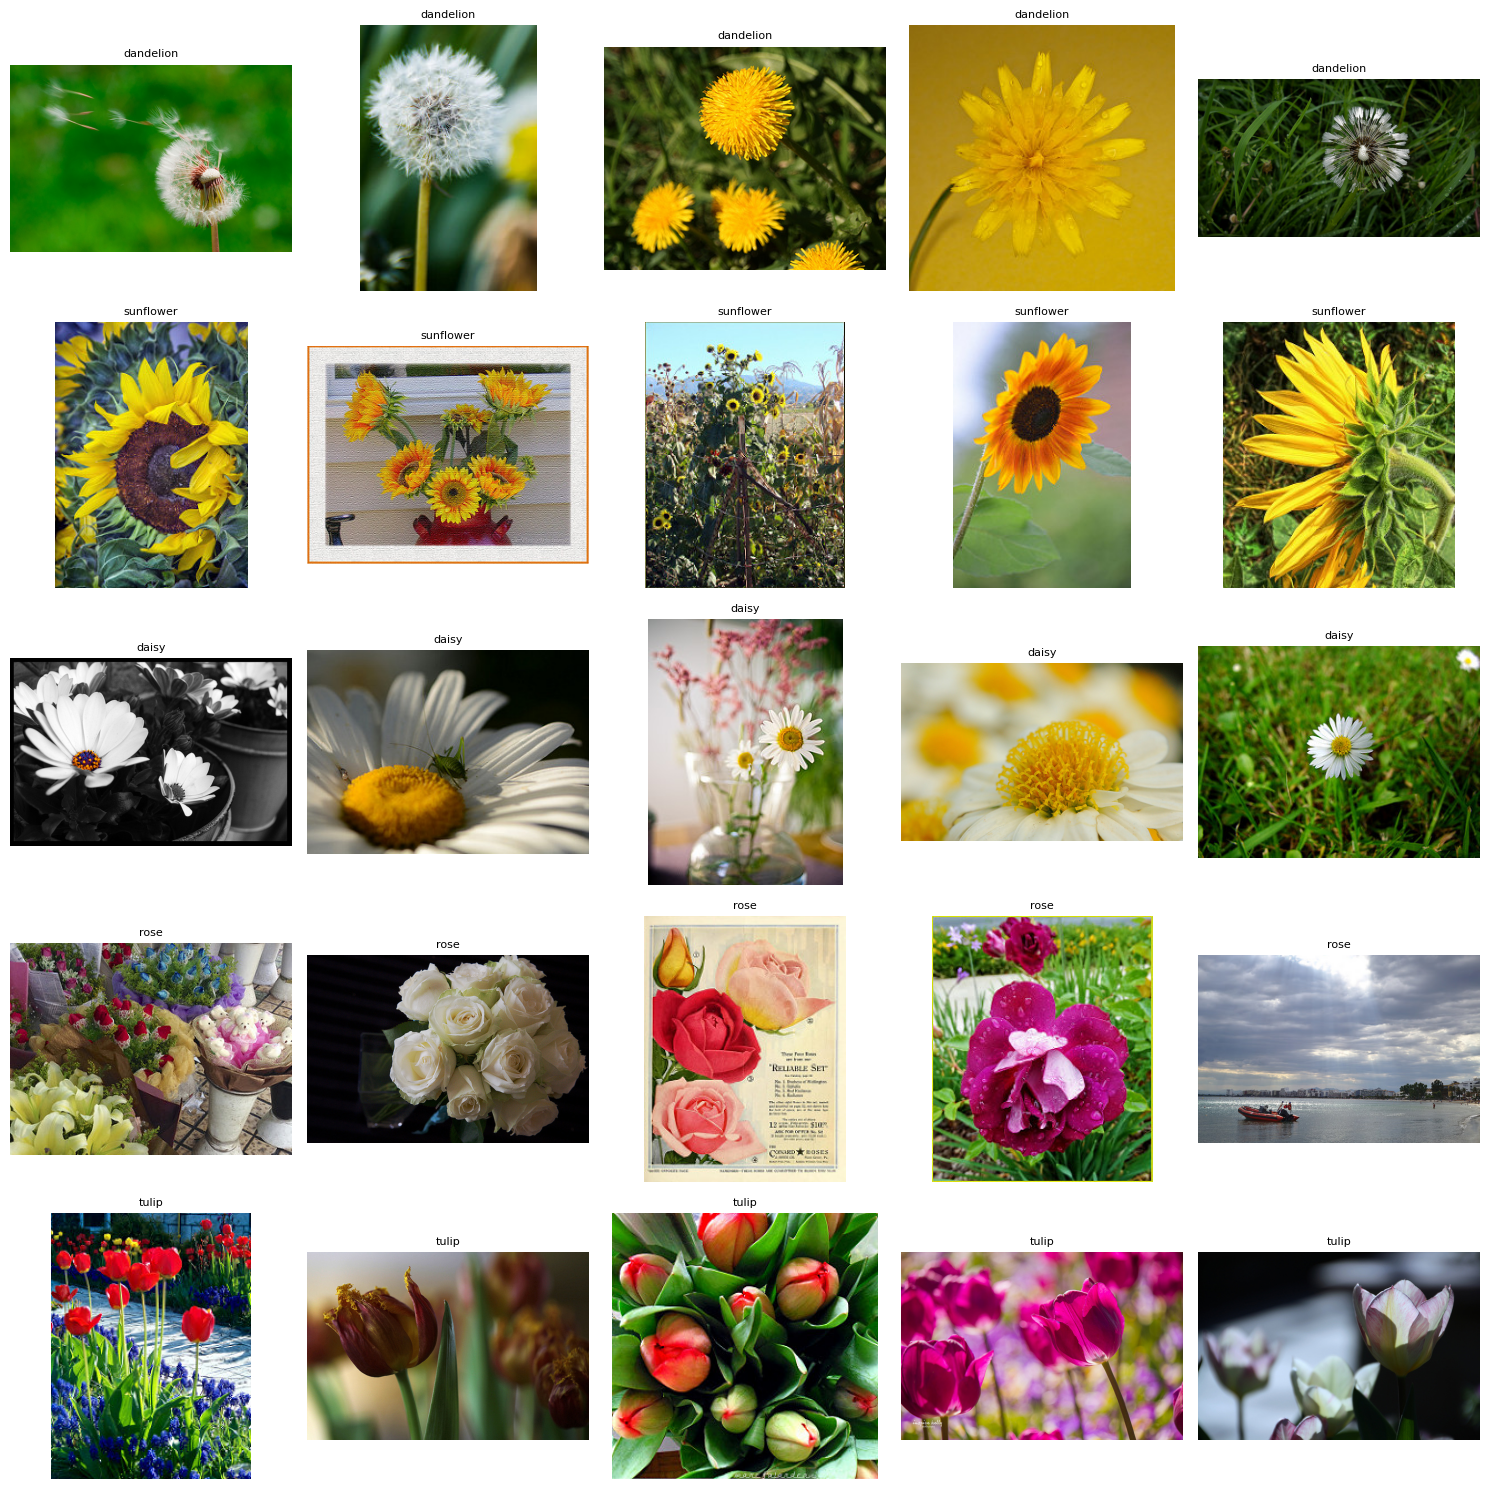

In [4]:
# Membuat dictionary untuk menyimpan gambar dari setiap kelas
flower_images = {}

for class_name in os.listdir(base_dir):
    flower_images[class_name] = os.listdir(os.path.join(base_dir, class_name))

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(flower_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(base_dir)):
    images = np.random.choice(flower_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(base_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

fig.tight_layout()
plt.show()

### Plot distribusi gambar di seluruh kelas

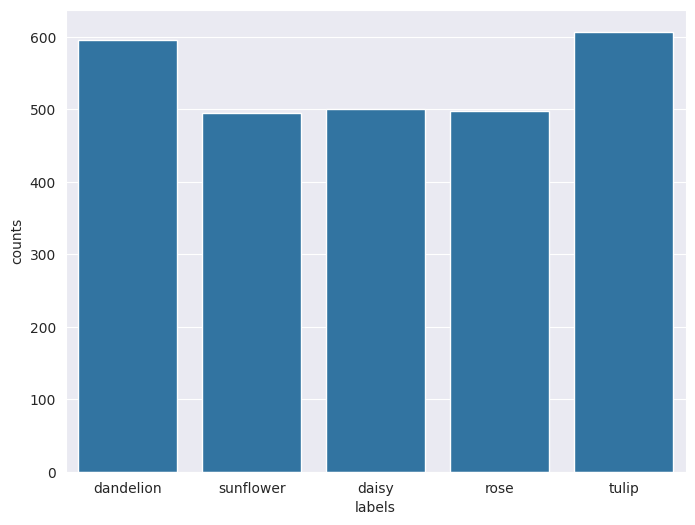

In [5]:
# Membuat list untuk menyimpan nama file, label, dan path gambar
file_name = []
labels = []
full_path = []

# Menelusuri semua gambar di folder dataset
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Mengambil nama folder sebagai label
        file_name.append(name)

# Membuat DataFrame untuk distribusi gambar
distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Membuat plot distribusi gambar per kelas
Label = distribution_train['labels']
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label)
plot_data.set_xlabel('labels')
plot_data.set_ylabel('counts')
plt.show()

## Data Preprocessing

### Split Dataset

In [6]:
# Memisahkan fitur dan label
X = distribution_train['path']
y = distribution_train['labels']

# Membagi data menjadi train (70%) dan temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Membagi temp menjadi validation (15%) dan test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Mengecek jumlah data setiap set
print(f"Jumlah data train       : {len(X_train)}")
print(f"Jumlah data validation  : {len(X_val)}")
print(f"Jumlah data test        : {len(X_test)}")

Jumlah data train       : 1887
Jumlah data validation  : 404
Jumlah data test        : 405


In [7]:
# Buat DataFrame untuk setiap set
df_train = pd.DataFrame({'path': X_train, 'label': y_train})
df_val = pd.DataFrame({'path': X_val, 'label': y_val})
df_test = pd.DataFrame({'path': X_test, 'label': y_test})

In [8]:
# Menampilkan jumlah gambar per kelas di setiap set
for set_name, df_set in {'Training': df_train, 'Validation': df_val, 'Testing': df_test}.items():
    print(f"\nJumlah gambar pada {set_name} set:")
    for label in df_set['label'].unique():
        count = df_set[df_set['label'] == label].shape[0]
        print(f"Total gambar kelas {label}: {count}")


Jumlah gambar pada Training set:
Total gambar kelas tulip: 425
Total gambar kelas dandelion: 417
Total gambar kelas sunflower: 346
Total gambar kelas rose: 348
Total gambar kelas daisy: 351

Jumlah gambar pada Validation set:
Total gambar kelas dandelion: 89
Total gambar kelas sunflower: 75
Total gambar kelas rose: 74
Total gambar kelas daisy: 75
Total gambar kelas tulip: 91

Jumlah gambar pada Testing set:
Total gambar kelas daisy: 75
Total gambar kelas sunflower: 74
Total gambar kelas tulip: 91
Total gambar kelas rose: 75
Total gambar kelas dandelion: 90


### Preprocessing dan Data Augmentation

In [9]:
# Ukuran gambar dan batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentasi hanya untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data validation dan data test hanya rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Generator untuk data validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1887 validated image filenames belonging to 5 classes.
Found 404 validated image filenames belonging to 5 classes.
Found 405 validated image filenames belonging to 5 classes.


## Modelling

In [10]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Menggunakan MobileNetV2 sebagai base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,023,525 (11.53 MB)

 Trainable params: 765,541 (2.92 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Setup callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Train model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5586 - loss: 1.0971 
Epoch 1: val_loss improved from inf to 0.47878, saving model to best_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 1398s 24s/step - accuracy: 0.5603 - loss: 1.0935 - val_accuracy: 0.8416 - val_loss: 0.4788 - learning_rate: 5.0000e-04
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7995 - loss: 0.5453
Epoch 2: val_loss improved from 0.47878 to 0.35142, saving model to best_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 693ms/step - accuracy: 0.7997 - loss: 0.5449 - val_accuracy: 0.8614 - val_loss: 0.3514 - learning_rate: 5.0000e-04
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8519 - loss: 0.4026
Epoch 3: val_loss did not improve from 0.35142
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 671ms/step - accuracy: 0.8519 - loss: 0.4027 - val_accuracy: 0.8540 - val_loss: 0.3922 - learning_rate: 5.0000e-04
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8735 - loss: 0.3567
Epoch 

## Evaluasi dan Visualisasi

In [12]:
# Evaluasi pada data train
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Akurasi Training Set   : {train_acc * 100:.2f}%")
print(f"Loss Training Set      : {train_loss:.4f}")

# Evaluasi pada data test
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Akurasi Testing Set    : {test_acc * 100:.2f}%")
print(f"Loss Testing Set       : {test_loss:.4f}")

Akurasi Training Set   : 95.65%
Loss Training Set      : 0.1241
Akurasi Testing Set    : 89.63%
Loss Testing Set       : 0.3487


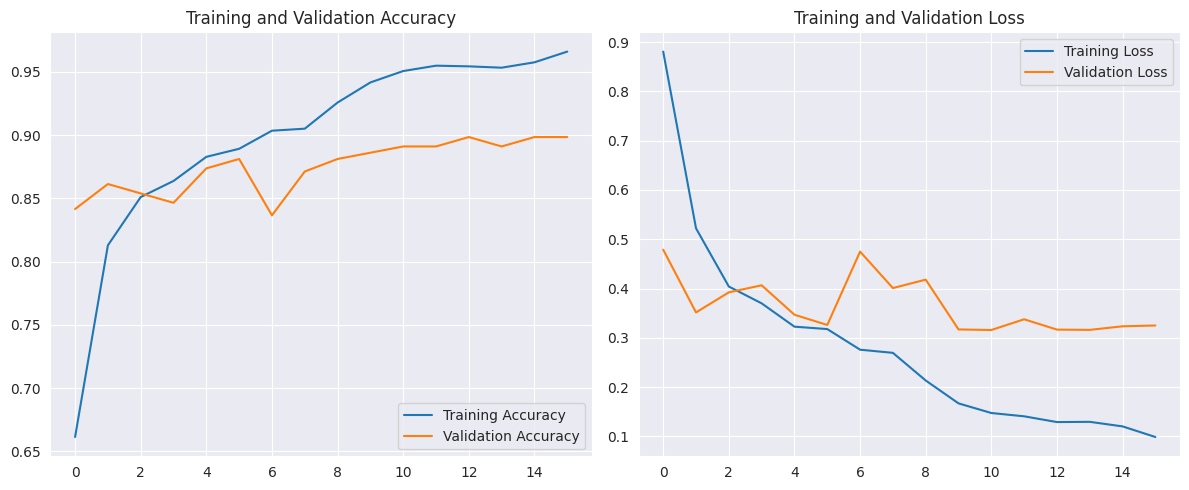

In [13]:
# Visualisasi akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step


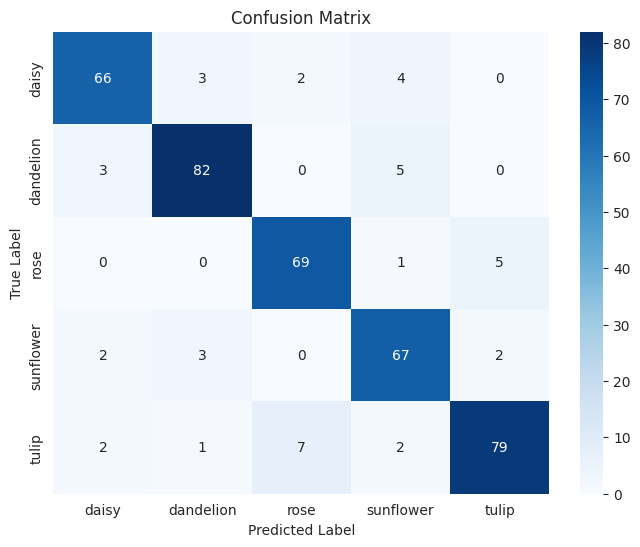

Classification Report:
              precision    recall  f1-score   support

       daisy       0.90      0.88      0.89        75
   dandelion       0.92      0.91      0.92        90
        rose       0.88      0.92      0.90        75
   sunflower       0.85      0.91      0.88        74
       tulip       0.92      0.87      0.89        91

    accuracy                           0.90       405
   macro avg       0.90      0.90      0.90       405
weighted avg       0.90      0.90      0.90       405



In [14]:
# Prediksi kelas
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Berdasarkan analisis pada confusion matrix, model klasifikasi bunga menunjukkan kinerja yang memuaskan dengan tingkat akurasi yang tinggi di hampir semua kelas. Kelas dandelion dan tulip tampil sangat baik, dengan jumlah prediksi yang benar tinggi serta kesalahan yang minimal. Namun, terdapat beberapa kebingungan di antara kelas-kelas, khususnya antara daisy dan sunflower, serta rose dan tulip. Hal ini mungkin disebabkan oleh kemiripan visual yang ada di antara jenis-jenis bunga tersebut.

## Konversi Model

In [15]:
# Simpan model dalam format SavedModel
saved_model_path = '/content/saved_model/flower_classifier'
model.export(saved_model_path)
print("Model berhasil disimpan dalam format SavedModel.")

Saved artifact at '/content/saved_model/flower_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137896627565392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540374992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540378064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540377680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540376720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540378256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540377296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540374416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540378448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137896540374800: TensorSpec(shape=(), dtype=tf.resource, n

In [16]:
# Simpan model dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

tflite_path = "/content/saved_model/flower_classifier.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("Model berhasil disimpan dalam format TF-Lite.")

Model berhasil disimpan dalam format TF-Lite.


In [21]:
# Simpan model dalam format TFJS
!tensorflowjs_converter --input_format=tf_saved_model \
  /content/saved_model/flower_classifier/ \
  /content/saved_model/flower_classifier/tfjs_model

print("Model berhasil disimpan dalam format TFJS.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-06 06:09:47.480284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746511787.501768   19395 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Inference (Optional)

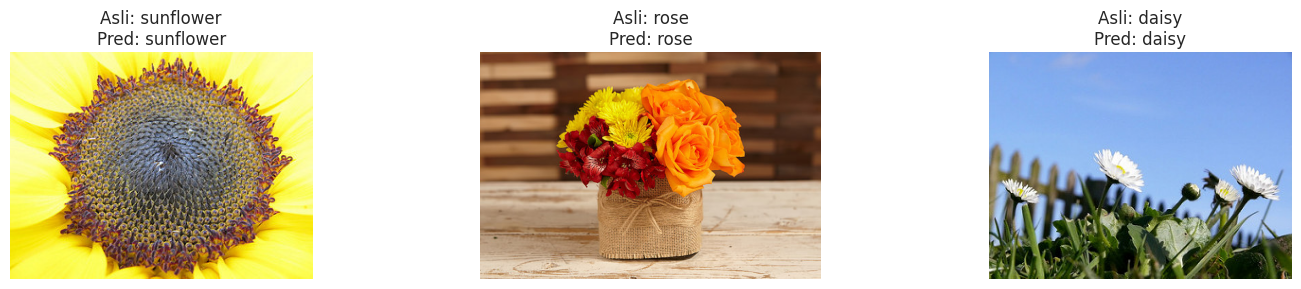

In [23]:
# Load interpreter TF-Lite
tflite_model_path = '/content/saved_model/flower_classifier.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Fungsi preprocessing gambar untuk TF-Lite (harus sesuai ukuran input model)
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  # Sesuaikan dengan ukuran input model
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array

# Ambil detail input dan output model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Daftar label kelas
class_labels = list(test_generator.class_indices.keys())

# Jumlah gambar yang ingin diuji
n_samples = 3

# Ambil sample acak dari data test
sample_df = df_test.sample(n=n_samples, random_state=42).reset_index(drop=True)
sample_paths = sample_df['path'].values
sample_labels = sample_df['label'].values

# Visualisasi dan inference
plt.figure(figsize=(15, 3))
for i in range(n_samples):
    img_path = sample_paths[i]
    true_label = sample_labels[i]

    # Preprocess
    input_image = preprocess_image(img_path)

    # Inference
    interpreter.set_tensor(input_details[0]['index'], input_image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = class_labels[predicted_index]

    # Tampilkan gambar
    img = Image.open(img_path)
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Asli: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()